In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses, initializers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pandas as pd
import utils

In [2]:
physical_gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

# 資料前處理

讀取資料集

In [14]:
dataset_path = "dataset.csv"
dataset = pd.read_csv(dataset_path)
dataset.drop(["Unnamed: 0"], axis="columns", inplace=True)
dataset.head()

,group,chinese,english,math,nature,society,physics
0,literature,72.492435,65.448919,18.169894,32.351591,96.402326,49.074423
1,literature,97.712323,68.422788,27.067687,47.742138,66.724955,46.866290
2,literature,88.636037,66.498265,42.349090,43.110598,63.040454,34.593495
3,literature,99.899684,73.103312,20.929818,46.384879,74.326143,52.849913
4,literature,82.656152,61.917569,21.044429,57.106996,54.139797,52.853023


隨機排序

In [15]:
data_num = dataset.shape[0]
indexes = np.random.permutation(data_num)
dataset = dataset.loc[indexes]
dataset.head()

,group,chinese,english,math,nature,society,physics
465,science,46.657013,77.960978,71.498167,82.900227,71.283980,83.603746
189,literature,86.632922,65.650457,26.955477,38.470583,42.308201,50.809259
296,science,37.324094,53.126066,86.613359,76.957717,6.182184,59.754612
374,science,50.298795,67.242522,89.335691,57.188052,17.273878,67.594298
65,literature,78.057492,58.202999,23.241113,24.539311,35.477260,38.342545


正規化

In [16]:
dataset["group"] = pd.factorize(dataset["group"])[0]
dataset.iloc[:, 1:] = dataset.iloc[:, 1:] / 100
dataset.head()

,group,chinese,english,math,nature,society,physics
465,0,0.466570,0.779610,0.714982,0.829002,0.712840,0.836037
189,1,0.866329,0.656505,0.269555,0.384706,0.423082,0.508093
296,0,0.373241,0.531261,0.866134,0.769577,0.061822,0.597546
374,0,0.502988,0.672425,0.893357,0.571881,0.172739,0.675943
65,1,0.780575,0.582030,0.232411,0.245393,0.354773,0.383425


分割成訓練、驗證、測試資料

In [17]:
train_data = dataset.iloc[:int(data_num * 0.6)]
val_data = dataset.iloc[int(data_num * 0.6):int(data_num * 0.8)]
test_data = dataset.iloc[int(data_num * 0.8):]

print(f"train_data = {train_data.shape}")
print(f"val_data = {val_data.shape}")
print(f"test_data = {test_data.shape}")

train_data = (300, 7)
val_data = (100, 7)
test_data = (100, 7)


拆分成 X、Y 資料

In [18]:
X_train = train_data.iloc[:, 1:]
Y_train = train_data.iloc[:, 0]
X_val = val_data.iloc[:, 1:]
Y_val = val_data.iloc[:, 0]
X_test = test_data.iloc[:, 1:]
Y_test = test_data.iloc[:, 0]
print(f"X_train = {X_train.shape}")
print(f"Y_train = {Y_train.shape}")
print(f"X_val = {X_val.shape}")
print(f"Y_val = {Y_val.shape}")
print(f"X_test = {X_test.shape}")
print(f"Y_test = {Y_test.shape}")

X_train = (300, 6)
Y_train = (300,)
X_val = (100, 6)
Y_val = (100,)
X_test = (100, 6)
Y_test = (100,)


# 模型訓練

模型建立

In [19]:
model = keras.Sequential([
    keras.Input(shape=(6,)),
    layers.Dense(16),
    layers.Dense(16),
    layers.Dense(1, activation="121295")
])
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics="binary_accuracy"
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                112       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


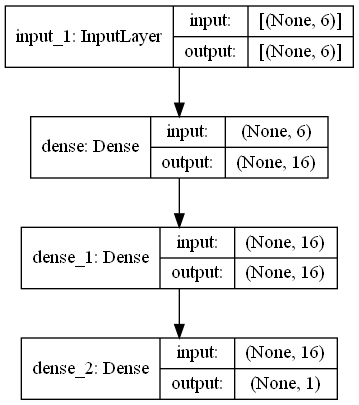

In [20]:
plot_model(model, show_shapes=True)

建立回調函數

In [21]:
callbacks = []
''' EarlyStopping '''
callbacks.append(
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=True, mode="auto")
)
''' ModelCheckpoint '''
callbacks.append(
    keras.callbacks.ModelCheckpoint("model.h5", monitor='val_loss', verbose=False, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
)
''' TensorBoard '''
callbacks.append(
  keras.callbacks.TensorBoard(log_dir="logs")
)

開始訓練

In [22]:
trainHistory = model.fit(
    X_train, Y_train,
    batch_size=64,
    epochs=100,
    validation_data=(X_val, Y_val),
    callbacks=callbacks
)

Epoch 1/100
5/5 [==============================] - 1s 110ms/step - loss: 0.6466 - binary_accuracy: 0.4600 - val_loss: 0.4968 - val_binary_accuracy: 0.6000
Epoch 2/100
5/5 [==============================] - 0s 15ms/step - loss: 0.5490 - binary_accuracy: 0.5200 - val_loss: 0.4465 - val_binary_accuracy: 0.7200
Epoch 3/100
5/5 [==============================] - 0s 15ms/step - loss: 0.4777 - binary_accuracy: 0.7500 - val_loss: 0.4146 - val_binary_accuracy: 0.8800
Epoch 4/100
5/5 [==============================] - 0s 17ms/step - loss: 0.4243 - binary_accuracy: 0.9400 - val_loss: 0.3966 - val_binary_accuracy: 0.9900
Epoch 5/100
5/5 [==============================] - 0s 20ms/step - loss: 0.3881 - binary_accuracy: 0.9967 - val_loss: 0.3843 - val_binary_accuracy: 0.9900
Epoch 6/100
5/5 [==============================] - 0s 18ms/step - loss: 0.3652 - binary_accuracy: 0.9967 - val_loss: 0.3721 - val_binary_accuracy: 0.9900
Epoch 7/100
5/5 [==============================] - 0s 18ms/step - loss: 0.3

畫出訓練結果

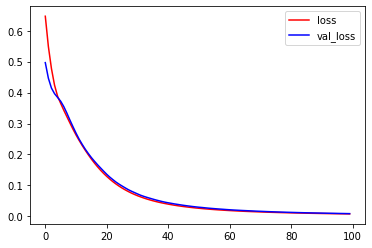

In [34]:
plt.plot(trainHistory.history['loss'], color='r', label='loss')
plt.plot(trainHistory.history['val_loss'], color='b', label='val_loss')
plt.legend()
plt.show()

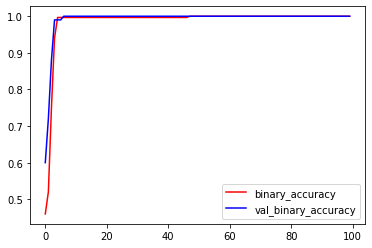

In [35]:
plt.plot(trainHistory.history['binary_accuracy'], color='r', label='binary_accuracy')
plt.plot(trainHistory.history['val_binary_accuracy'], color='b', label='val_binary_accuracy')
plt.legend()
plt.show()

# 測試結果

載入最佳模型

In [25]:
best_model = load_model("model.h5")

模型驗證

In [26]:
result = best_model.evaluate(X_test, Y_test)
print(f"Loss = {result[0]}, ACC = {result[1] * 100}%")

4/4 [==============================] - 0s 4ms/step - loss: 0.0072 - binary_accuracy: 1.0000
Loss = 0.007184217683970928, ACC = 100.0%


模型預測

In [27]:
predict = best_model.predict(X_test)
Y_pred = (predict >= 0.5)

畫出混淆矩陣

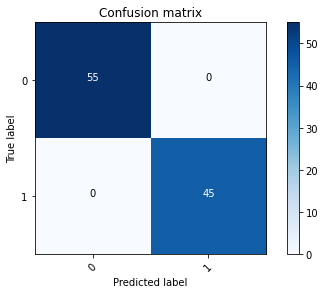

In [28]:
utils.plot_confusion_matrix(Y_test, Y_pred, 2)

# 實際應用

自行設計模型預測API

In [29]:
def run_model(data):
    input_data = np.array([
        data["chinese"],
        data["english"],
        data["math"],
        data["nature"],
        data["society"],
        data["physics"]
    ])
    input_data = input_data / 100
    input_data = input_data[np.newaxis, :]
    predict = model.predict(input_data)
    output_data = {
        "literature" : 1 - predict[0][0],
        "science" : predict[0][0]
    }
    return output_data

使用範例

In [36]:
input_data = {
    "chinese" : 50,
    "english" : 60,
    "math" : 80,
    "nature" : 50,
    "society" : 50,
    "physics" : 50
}

result = run_model(input_data)

print(f"{int(result['literature'] * 100)}% is Literature")
print(f"{int(result['science'] * 100)}% is Science")

79% is Literature
20% is Science
